In [137]:
import numpy as np
import matplotlib.pyplot as plt

In [138]:
def inverse_jacobian(x,y1,y2,l_0,k_0):
    det             = 1 + np.exp( 2*x ) * ( y1 + y2 - l_0 ) * ( 2*y1 + 2*y2 - 2*k_0 -l_0 ) + np.exp( x ) * ( k_0 + l_0 - 3*y2 )
    inverse_matrix  = np.array( [[ - 1 + np.exp(x) * ( 2*y2 - l_0 ) ,         - 1 + np.exp(x) * (k_0 - y1)       ], 
                                 [   np.exp(x) * ( 2*y1 - l_0 )     , - 1 + np.exp(x) * ( 2*y1 + y2 - k_0 - l_0 )]] )
    return  (1/det)* inverse_matrix


def ecuation_system(x,y1,y2,l_0,k_0):
    matrix          = np.array( [ np.exp(x) * ( l_0 - y1 - y2 ) * ( k_0 -y1 ) - ( y1 - y2 ) , np.exp(x) * ( l_0 - y1 - y2 ) * ( y1 - y2 ) - y2 ] )
    return matrix


In [139]:
# Parametros necesarios para el calculo

y1_0       = 0.3                                         #Aproximaciones inciales de avance relativo xi_1
y2_0       = 0.3                                         #Aproximaciones inciales de avance relativo xi_2

n          = np.linspace(0.001, 1.0, 500, endpoint=True)  #Densidades a explorar   

l_0        = 1.0                                         #Cantidad relativa inicial de coloide cerradura
k_0        = 1.0                                         #Cantidad relativa inicial de coloide llave
alpha      = 1.0                                         #Constante empirica
lambda_    = 1.0                                         #Constante empirica

# Potenciales de reaccion
beta_u_ef_con_dEC  = np.loadtxt("beta_u_llave_cerradura_2D_contacto_dEC.csv", delimiter=",")[:,1]     #Potencial primer corrida
beta_u_ef_con_s_2  = np.loadtxt("beta_u_llave_cerradura_2D_contacto_sigma_2.csv", delimiter=",")[:,1] #Potencial segunda corrida  

# Parametros del sistema
sigma_3            = 1.0                                         #Diametro depletantes
sigma_1            = 10.0 * sigma_3                              #Diametro coloide cerradura
sigma_2_est        = 10.0 * sigma_3                              #Diametro coloide llave (1 corrida)
sigma_2_din        = np.loadtxt("beta_u_llave_cerradura_2D_contacto_sigma_2.csv", delimiter=",")[:,0]  #Diametro coloide llave (2 corrida)
dEC_est            = 5.0  * sigma_3                              #Distancia Cerradura - Hueco (2 corrida)
dEC_din            = np.loadtxt("beta_u_llave_cerradura_2D_contacto_dEC.csv", delimiter=",")[:,0]  #Distancia Cerradura - Hueco (1 corrida)



N_max      = 1000                                        #Numero maximo de pasos permitidos
tol        =  1 / 100000                                 #Tolerancia de aceptación

grado_avance_1 = np.zeros((len(n),len(beta_u_ef_con_dEC)))
grado_avance_2 = np.zeros((len(n),len(beta_u_ef_con_dEC)))

In [114]:
for z in range(2):
    if z==0: 
        beta_u_ef_a = beta_u_ef_con_dEC 
        char        = 'dEC'
    else:
        beta_u_ef_a = beta_u_ef_con_s_2
        char        = 's2'
        
    for j in range(len(n)):
        #Recorrer la lista de densidades a explorar
        n_0              = n[j]
        for k in range(len(beta_u_ef_a)):
            beta_u_ef_nor = beta_u_ef_a[k]
            beta_u_ef     = beta_u_ef_nor * n_0 
            x             = - alpha * beta_u_ef + np.log( n_0 * lambda_ )
            
            i             = 0
            aprox         = np.array( [ y1_0 , y2_0 ] )
            
            while i <= N_max:
                correccion = - np.matmul(inverse_jacobian(x,aprox[0],aprox[1],l_0,k_0) , ecuation_system( x, aprox[0], aprox[1], l_0, k_0 ) )
                aprox     = aprox + correccion
            
                if np.linalg.norm(correccion) < tol:
                    break
                i  += 1
                  
            grado_avance_1[j,k] = aprox[0]
            grado_avance_2[j,k] = aprox[1]
    
    np.savetxt('Grado_avance_1_' + char + '.csv', grado_avance_1, delimiter=",")
    np.savetxt('Grado_avance_2_' + char + '.csv', grado_avance_2, delimiter=",")

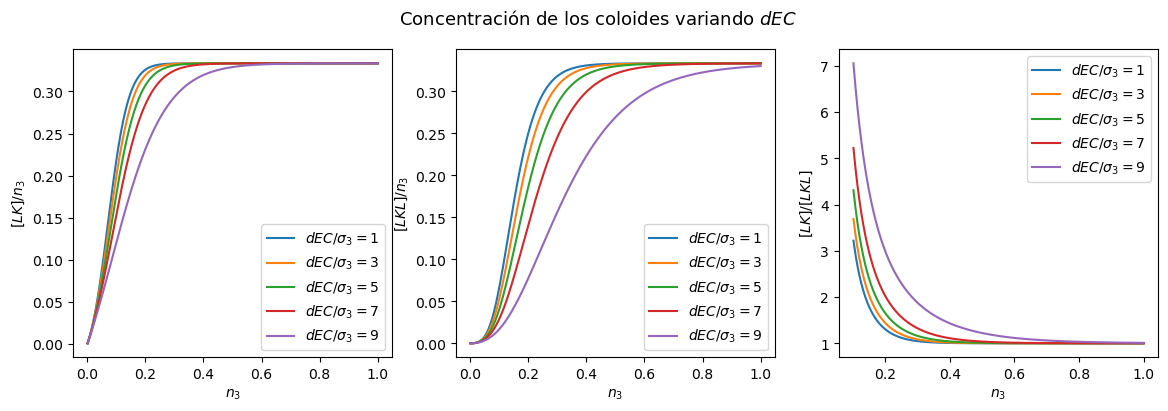

In [142]:
#Gráfico primer corrida 
# sigma_1 = sigma_2 = 10 sigma_3
# l_0 = k_0 = 1.0
# alpha = lambda = 1

xi_1 = np.loadtxt('Grado_avance_1_dEC.csv', delimiter=",")
xi_2 = np.loadtxt('Grado_avance_2_dEC.csv', delimiter=",")

fig, axs = plt.subplots(1,3,figsize=[14, 4])

for j in range(len(dEC_din)):
    concetracion_LK  = xi_1[:,j] - xi_2[:,j]
    concetracion_LKL = xi_2[:,j]
    axs[0].plot( n, concetracion_LK, label=r'$dEC/\sigma_3=$'+str(int(dEC_din[j])))
    axs[1].plot( n, concetracion_LKL, label=r'$dEC/\sigma_3=$'+str(int(dEC_din[j])))
    axs[2].plot( n[50 :], concetracion_LK[50 :]/concetracion_LKL[50 :], label=r'$dEC/\sigma_3=$'+str(int(dEC_din[j])))
   

axs[0].set_ylabel(r'$[LK]/n_3$')
axs[0].set_xlabel(r'$n_3$')
axs[0].legend()

axs[1].set_ylabel(r'$[LKL]/n_3$')
axs[1].set_xlabel(r'$n_3$')
axs[1].legend()

axs[2].set_ylabel(r'$[LK]/[LKL]$')
axs[2].set_xlabel(r'$n_3$')
axs[2].legend()


fig.suptitle(r'Concentración de los coloides variando $dEC$', fontsize=13)
plt.savefig("Grafico_estatica_biensamblados_dEC.png", dpi=500)
plt.show()

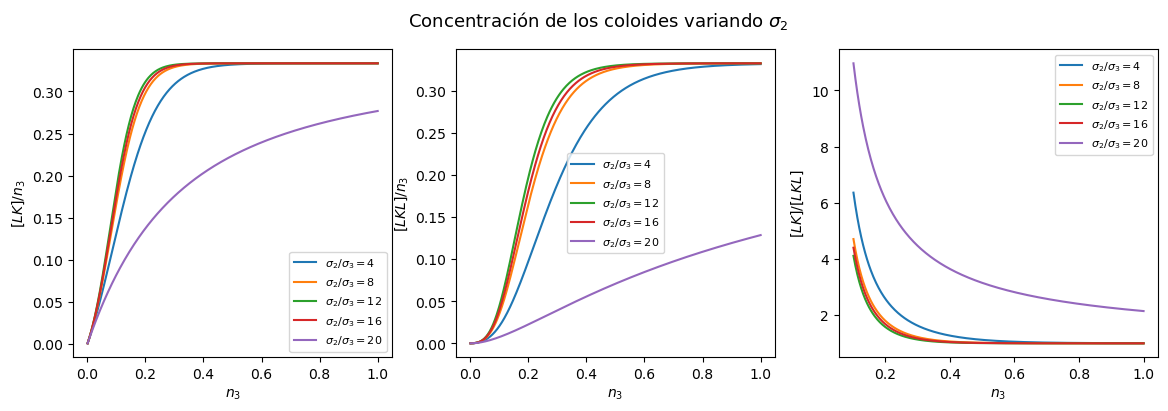

In [146]:
#Gráfico segunda corrida 
# sigma_1 = sigma_2 = 10 sigma_3
# l_0 = k_0 = 1.0
# alpha = lambda = 1

xi_1 = np.loadtxt('Grado_avance_1_s2.csv', delimiter=",")
xi_2 = np.loadtxt('Grado_avance_2_s2.csv', delimiter=",")

fig, axs = plt.subplots(1,3,figsize=[14, 4])

for j in range(len(sigma_2_din)):
    concetracion_LK  = xi_1[:,j] - xi_2[:,j]
    concetracion_LKL = xi_2[:,j]
    axs[0].plot( n, concetracion_LK , label=r'$\sigma_2/\sigma_3=$'+str(int(sigma_2_din[j])))
    axs[1].plot( n, concetracion_LKL, label=r'$\sigma_2/\sigma_3=$'+str(int(sigma_2_din[j])))
    axs[2].plot( n[50 :], concetracion_LK[50 :]/concetracion_LKL[50 :], label=r'$\sigma_2/\sigma_3=$'+str(int(sigma_2_din[j])))
   

axs[0].set_ylabel(r'$[LK]/n_3$')
axs[0].set_xlabel(r'$n_3$')
axs[0].legend(prop={'size': 8})

axs[1].set_ylabel(r'$[LKL]/n_3$')
axs[1].set_xlabel(r'$n_3$')
axs[1].legend(prop={'size': 8})

axs[2].set_ylabel(r'$[LK]/[LKL]$')
axs[2].set_xlabel(r'$n_3$')
axs[2].legend(prop={'size': 8})

fig.suptitle(r'Concentración de los coloides variando $\sigma_2$', fontsize=13)
plt.savefig("Grafico_estatica_biensamblados_s2.png", dpi=500)
plt.show()